In [118]:
#imports
import pandas as pd
import numpy as np
from numpy import loadtxt
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [78]:
df = pd.read_csv('..\data\s4_ow_cleaned.csv')

In [79]:
df.head()

,Hero,Skill Tier,KDA Ratio,"Pick Rate, %","Win Rate, %",Eliminations / 10min,Objective Kills / 10min,Objective Time / 10min,Damage / 10min,Healing / 10min,Deaths / 10min,"Scoped Accuracy, %",Role
0,Ana,All,4.23,9.57,49.30,9.28,3.86,62,2636,8181.0,5.95,57.0,Support
1,Ana,Bronze,3.93,3.74,44.70,8.66,3.86,60,2586,7135.0,6.38,52.0,Support
2,Ana,Silver,4.14,4.52,47.07,8.99,4.02,63,2589,7495.0,6.29,53.0,Support
3,Ana,Gold,4.21,6.51,48.72,9.15,4.02,63,2578,7839.0,6.12,54.0,Support
4,Ana,Platinum,4.31,9.68,48.97,9.41,4.00,63,2626,8186.0,5.97,56.0,Support


In [80]:
df_x = df.drop(['Pick Rate, %', 'Healing / 10min', 'Scoped Accuracy, %' ], axis=1)

In [81]:
df_x.head()

,Hero,Skill Tier,KDA Ratio,"Win Rate, %",Eliminations / 10min,Objective Kills / 10min,Objective Time / 10min,Damage / 10min,Deaths / 10min,Role
0,Ana,All,4.23,49.30,9.28,3.86,62,2636,5.95,Support
1,Ana,Bronze,3.93,44.70,8.66,3.86,60,2586,6.38,Support
2,Ana,Silver,4.14,47.07,8.99,4.02,63,2589,6.29,Support
3,Ana,Gold,4.21,48.72,9.15,4.02,63,2578,6.12,Support
4,Ana,Platinum,4.31,48.97,9.41,4.00,63,2626,5.97,Support


In [82]:
df_x = df_x[df_x['Skill Tier'] != 'All']

In [83]:
df_x.head()

,Hero,Skill Tier,KDA Ratio,"Win Rate, %",Eliminations / 10min,Objective Kills / 10min,Objective Time / 10min,Damage / 10min,Deaths / 10min,Role
1,Ana,Bronze,3.93,44.70,8.66,3.86,60,2586,6.38,Support
2,Ana,Silver,4.14,47.07,8.99,4.02,63,2589,6.29,Support
3,Ana,Gold,4.21,48.72,9.15,4.02,63,2578,6.12,Support
4,Ana,Platinum,4.31,48.97,9.41,4.00,63,2626,5.97,Support
5,Ana,Diamond,4.25,49.34,9.48,3.87,62,2681,5.89,Support


In [84]:
df_x.dtypes

Hero                        object
Skill Tier                  object
KDA Ratio                  float64
Win Rate, %                float64
Eliminations / 10min       float64
Objective Kills / 10min    float64
Objective Time / 10min       int64
Damage / 10min               int64
Deaths / 10min             float64
Role                        object
dtype: object

In [85]:
df_x['Skill Tier'].unique()

array(['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master',
       'Grandmaster'], dtype=object)

In [86]:
df_x.isna().sum()

Hero                       0
Skill Tier                 0
KDA Ratio                  0
Win Rate, %                0
Eliminations / 10min       0
Objective Kills / 10min    0
Objective Time / 10min     0
Damage / 10min             0
Deaths / 10min             0
Role                       0
dtype: int64

In [87]:
df_x['Hero'].unique()

array(['Ana', 'Mercy', 'Genji', 'Cassidy', 'Kiriko', 'Hanzo', 'Moira',
       'Reinhardt', 'Widowmaker', 'Soldier: 76', 'Zenyatta', 'D.Va',
       'Lucio', 'Tracer', 'Junkrat', 'Ashe', 'Zarya', 'Baptiste',
       'Roadhog', 'Reaper', 'Pharah', 'Sigma', 'Doomfist', 'Brigitte',
       'Mei', 'Orisa', 'Winston', 'Sombra', 'Bastion', 'Symmetra',
       'Wrecking Ball', 'Ramattra', 'Torbjorn', 'Lifeweaver', 'Sojourn',
       'Junker Queen', 'Echo'], dtype=object)

In [88]:
X = df_x.drop('Skill Tier', axis=1).copy()
X.head()

,Hero,KDA Ratio,"Win Rate, %",Eliminations / 10min,Objective Kills / 10min,Objective Time / 10min,Damage / 10min,Deaths / 10min,Role
1,Ana,3.93,44.70,8.66,3.86,60,2586,6.38,Support
2,Ana,4.14,47.07,8.99,4.02,63,2589,6.29,Support
3,Ana,4.21,48.72,9.15,4.02,63,2578,6.12,Support
4,Ana,4.31,48.97,9.41,4.00,63,2626,5.97,Support
5,Ana,4.25,49.34,9.48,3.87,62,2681,5.89,Support


In [89]:
y = df_x['Skill Tier'].copy()
y.head()

1      Bronze
2      Silver
3        Gold
4    Platinum
5     Diamond
Name: Skill Tier, dtype: object

In [90]:
# utilizing one-hot encoding to allow our model to give us a more accurate response
X_encoded = pd.get_dummies(X, columns=['Hero', 'Role'])

In [91]:
X_encoded.head()

,KDA Ratio,"Win Rate, %",Eliminations / 10min,Objective Kills / 10min,Objective Time / 10min,Damage / 10min,Deaths / 10min,Hero_Ana,Hero_Ashe,Hero_Baptiste,...,Hero_Torbjorn,Hero_Tracer,Hero_Widowmaker,Hero_Winston,Hero_Wrecking Ball,Hero_Zarya,Hero_Zenyatta,Role_Damage,Role_Support,Role_Tank
1,3.93,44.70,8.66,3.86,60,2586,6.38,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,4.14,47.07,8.99,4.02,63,2589,6.29,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,4.21,48.72,9.15,4.02,63,2578,6.12,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,4.31,48.97,9.41,4.00,63,2626,5.97,True,False,False,...,False,False,False,False,False,False,False,False,True,False
5,4.25,49.34,9.48,3.87,62,2681,5.89,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [92]:
y.unique()

array(['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master',
       'Grandmaster'], dtype=object)

In [93]:
y.head()

1      Bronze
2      Silver
3        Gold
4    Platinum
5     Diamond
Name: Skill Tier, dtype: object

In [94]:
y = y.astype('category')

In [95]:
y = pd.get_dummies(y, columns=['Skill Tier'])

In [96]:
# converting y values to int
columns_to_convert = ['Bronze',	'Diamond',	'Gold',	'Grandmaster','Master',	'Platinum',	'Silver']
y[columns_to_convert] = y[columns_to_convert].astype(int)

In [97]:
y.head()

,Bronze,Diamond,Gold,Grandmaster,Master,Platinum,Silver
1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0
5,0,1,0,0,0,0,0


In [98]:
print(X_encoded.shape, y.shape)

(259, 47) (259, 7)


In [99]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# XGBoost regressor model for regression
model = xgb.XGBRegressor(objective='reg:squarederror')

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.19141102032832796


It looks like your model evaluation using Mean Squared Error (MSE) was successful, and the resulting MSE is approximately 0.1914. The MSE is a measure of the average squared difference between the predicted and actual values. In the context of regression problems, a lower MSE generally indicates better model performance.

In [124]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# XGBoost regressor model for regression
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X_encoded, y)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 0.19141102032832796


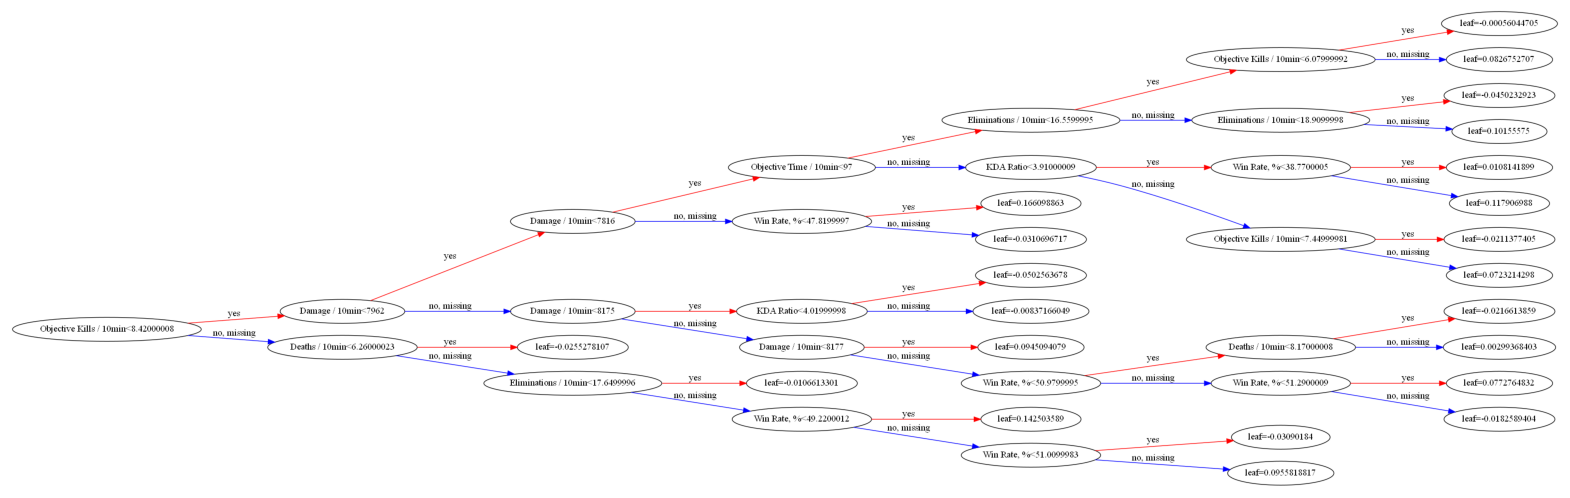

In [150]:
# save plot
fig, ax = plt.subplots(figsize=(20, 20), dpi=100)
plot_tree(model, num_trees=20, rankdir='LR', ax=ax)

for text in ax.texts:
    text.set_fontsize(10)
plt.savefig('../images/XGBoost_tree_LR.png')

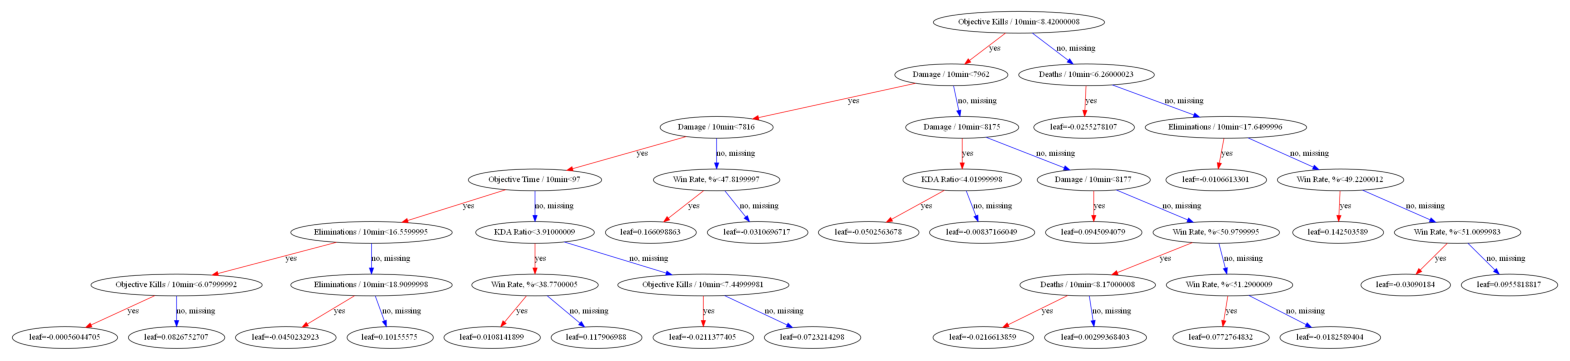

In [149]:

fig, ax = plt.subplots(figsize=(20, 20), dpi=100)
plot_tree(model, num_trees=20, rankdir='TB', ax=ax)

for text in ax.texts:
    text.set_fontsize(10)
plt.savefig('../images/XGBoost_tree.png')

In [110]:
y_test_df = pd.DataFrame(y_test, columns=['Bronze',	'Diamond',	'Gold',	'Grandmaster','Master',	'Platinum',	'Silver'])
predictions_df = pd.DataFrame(predictions, columns=['Bronze',	'Diamond',	'Gold',	'Grandmaster','Master',	'Platinum',	'Silver'])